# Non-stationary Contextual Multi-armed Bandit
## Introduction

- Contextual MAB aims to find the best policy given context features as side information.
- One key assumption: the underlying relationship between context features and rewards are fixed or move very slowly.

### Problem
- In many real world situations, this is not the case. 
- Factors can change suddenly and dramatically (non-stationary)

### Examples
- a user's interest in watching the NBA would suddenly drop in June when the season is over. 
- a user moved to another city or country.

Therefore, in these situations, many alogrithms will be stuck in sub-optimal decisions for a long-time or forever.

### Demonstration
This notebook implemented a popular contextual bandit algorithm: LinUCB
And applied this algorithm in both a stationary and a non-stationary environment.
The result plots can be found at very bottom.
We can see that in this simulation setup, given a stationary environment, our policy converges to optimal in about 20 timesteps. However, given the same setup, and we make a sudden change in the environment half-way. It takes almost 60 timestamp to converge again, and along the way accumulated large regrets. This is because after the first convergence, our model already has strong belief and it's much harder and slower to update.


### Solutions
We will focus on one of the solutions to this problem. 

The dLinUCB algorithm proposed by Wu et al in 
__[Learning Contextual Bandits in a Non-stationary Environment](https://arxiv.org/pdf/1805.09365.pdf)__ 


## Background
One of the popular algorithms for contextual bandit is the LinUCB.

$E[r_{t,a}|x_{t,a}] = x_{t,a}^{T}\theta_{a}^{*}$

x is context features, $\theta$ is weights. So assumes the expected reward for an action under given context is a linear combination of features.

Weights are calculated by a ridge regression over all the previous contexts encountered vs observed reward


## References
[1] Lihong Li, Wei Chu, John Langford, and Robert E Schapire. 2010. A contextualbandit
approach to personalized news article recommendation. In Proceedings of
19th WWW. ACM, 661–670.

[2]Wu, Q., Iyer, N. and Wang, H., 2018. Learning Contextual Bandits in a Non-stationary Environment. arXiv preprint arXiv:1805.09365.

In [13]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from numpy.linalg import inv
plt.style.use('seaborn-whitegrid')

#Generate ground truth models
#Here we assume the reward is linear in the context.
#each action has a theta which is the weights for the context feature vector
np.random.seed(0)


In [14]:
#contextual MAB
class Bandit():
    def __init__(self, n_feature, n_action, policy):
        self.policy = policy
        self.thetas = np.zeros((n_action,n_feature))
        self.n_a = n_action
        self.n_f = n_feature
        self.Ds = [np.zeros(3).reshape(1,3)] * self.n_a
        self.Cs = [0] * self.n_a
        
    def pick_action(self,x):
        if self.policy == 'random':
            return np.random.randint(0,self.n_a)
        elif self.policy == 'egreedy':
            if np.random.rand()<0.2:
                return np.random.randint(0,self.n_a)
            else:
                return np.argmax([np.dot(x,self.thetas[a]) for a in range(self.n_a)])
        elif self.policy == 'LinUCB':
            delta = 0.3
            max_E = np.NINF
            best_a = 0
            for a in range(self.n_a):
                D = self.Ds[a]
                A = np.dot(D.T,D) + np.identity(self.n_f)
                A_inverse = inv(A)
                alpha = 1. + np.sqrt(np.log(2./delta)/2.)
                bound = alpha * np.sqrt(np.dot(np.dot(x.T, A_inverse), x))
                E = np.dot(x.T,self.thetas[a]) + bound
                if E > max_E:
                    max_E = E
                    best_a = a
                
            return best_a
        else:
            raise Exception('no policy found')
    def update_model(self,x,a,r):
        d = len(x)
        self.Ds[a] = np.append(self.Ds[a],[x],axis=0)
        self.Cs[a] = np.append(self.Cs[a],r)
        D = self.Ds[a]
        C = self.Cs[a]
        inverse = inv(np.dot(D.T, D) + np.identity(d))
        new_theta = np.dot(np.dot(inverse,D.T), C)
        self.thetas[a] = new_theta
        
    



Experiment Starts
Ground truth thetas
action 0: [-1.35355949 -0.8544319  -1.19170987]
action 1: [-1.36535045 -1.7290356  -1.06231766]
action 2: [-1.68723837 -0.324681   -0.10901172]
action 3: [-1.84967544 -0.62482489 -1.41331524]
action 4: [-1.29586632 -0.22321009 -2.78689183]
Estimated thetas
action 0: [-1.35398341 -0.85339029 -1.13236599]
action 1: [-1.34275059 -1.65421281 -1.09278986]
action 2: [-1.67934355 -0.32619043 -0.11354877]
action 3: [-1.76903617 -0.64080429 -1.41994801]
action 4: [-1.31129627 -0.22471871 -2.66595127]


Experiment Starts
Ground truth thetas
action 0: [-1.35355949 -0.8544319  -1.19170987]
action 1: [-1.36535045 -1.7290356  -1.06231766]
action 2: [-1.68723837 -0.324681   -0.10901172]
action 3: [-1.84967544 -0.62482489 -1.41331524]
action 4: [-1.29586632 -0.22321009 -2.78689183]
env changed!
Ground truth thetas
action 0: [-2.06416501 -1.80533681 -2.37046875]
action 1: [-2.44142098 -0.16688283 -0.78134761]
action 2: [-1.52862357 -2.31775612 -2.23693055]
action

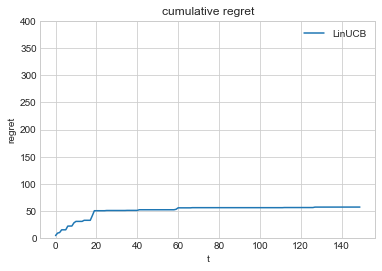

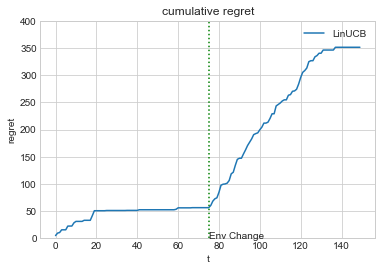

In [15]:
#run simulation
class Experiment():
    def __init__(self, iter, policy, non_stationary):
        self.policy = policy
        self.iterations = iter
        self.non_stationary = non_stationary
        self.n_feature = 3
        self.n_action = 5
        self.true_thetas = None
        
    def get_true_reward(self, x,a):
        return np.dot(x,self.true_thetas[a])
    
    def get_rand_context(self):
        return np.random.randint(0,5,(self.n_feature))
    
    def gen_true_thetas(self):
        self.true_thetas = np.random.rand(self.n_action,self.n_feature) * 3. - 3.
        print('Ground truth thetas')
        for a in range(self.n_action):
            print('action ' + str(a) + ': ' + str(self.true_thetas[a]))
    
    def get_optimal_action(self,x):
        return np.argmax([self.get_true_reward(x,a) for a in range(self.n_action)])
    
    def run(self):
        print('\n\nExperiment Starts')
        np.random.seed(0)
        regret = 0.
        regret_list = []
        t_change = np.floor(self.iterations * 0.5)
        model = Bandit(self.n_feature, self.n_action, self.policy)
        self.gen_true_thetas()
        for t in range(self.iterations):
            context = self.get_rand_context()
            a = model.pick_action(context)
            r = self.get_true_reward(context,a)
            model.update_model(context,a,r)
            regret += abs(r - self.get_true_reward(context,self.get_optimal_action(context)))
            regret_list.append(regret)

            if self.non_stationary and t == t_change:
                print('env changed!')
                self.gen_true_thetas()

        print('Estimated thetas')
        for a in range(model.n_a):
            print('action ' + str(a) + ': ' + str(model.thetas[a]))
        
        fig,ax = plt.subplots()
        ax.set_title('cumulative regret')
        ax.set_xlabel('t')
        ax.set_ylabel('regret')
        ax.set_ylim(0.,400.)
        ax.plot(regret_list, label=self.policy)
        if self.non_stationary:
            ax.axvline(x=t_change,linestyle=':',color='green')
            ax.text(t_change,0.,'Env Change')
        ax.legend()

        return


ITERATIONS = 150
exp1 = Experiment(ITERATIONS,'LinUCB',False)
exp2 =  Experiment(ITERATIONS,'LinUCB',True)
exp1.run()
exp2.run()
